# Test Dataset Creation

For part of this project, we will develop our own custom testing dataset for twitter sentiment analysis. This dataset will be roughly 500 entries long and will be hand labelled with the following classes: Positive, Neutral, Negative. This notebook will walk the reader through the steps taken to create the test dataset.

## Objective

The objective is to create a high-quality and original dataset for sentiment analysis sourced from the statuses table of the Twitter PostgreSQL Database. We chose to use the PostgreSQl Database instead of the MongoDB Database because the RDBMS table-based system of PostgreSQL is formatted much better to use with AI/ML libraries than the NoSQL JSON format of MongoDB. This is because we can directly query the data from a PostgreSQL table into a Pandas Dataframe, which is the format all of the Python AI libraries take. As mentioned before, the dataset will consist of around 500 unique tweets taken from the twitter.statuses table. Each row entry will consist of the full tweet text and a multiclass label (Positive, Neutral, Negative). The dataset size being at 500 is only because this is the minimum length I feel would still produce meaningful results. Larger datasets are always beigger, but since we are hand-labelling the data, we are limited on dataset size. 

## Approach

1. Connect to Twitter PostgreSql database
2. Load 500 entries into a Pandas Dataframe.
3. Reformat data.
4. Export data to a CSV with placeholder labels.
5. Go through dataset by hand and label every entry.
6. Display resulting dataset and show some distributions, etc. 

If you are curious about the actualy sentiment analysis, see the file "SentimentAnalysis.ipynb". I will start by importing the necessary libraries, setting up functions, and connecting to the Twitter comp_dbms PostgreSQL 

In [61]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import emoji
import re

In [62]:
# Function to replace emojis in text with their textual representations
#   Input: String representing a tweet text
#   Output: De-Emojied String
def replace_emojis(text):
    # Use the 'demojize' function from the emoji library
    return emoji.demojize(text, delimiters=("", ""))

### Step 1.
Now I will connect to the database and display some basic information about the table twitter.statuses. This is where we will be getting the data to construct the dataset.

In [63]:
# Connect to the database
connection = psycopg2.connect(host='3.230.203.12',
                             user='compdb',
                             port=5438,
                             database='twitter',
                             password='compdbs_postgres')
connection.set_session(readonly=True, autocommit=True)

#From our connection we need a cursor, which acts as our interface into the database
cur = connection.cursor()

## Step 2. 

Now I will load 500 entries from the twitter.statuses table into a Pandas Dataframe. I built this specific query for 3 reasons. First, I use distinct(status_id) to make sure there are not duplicate statuses. This is important because repeated entries can lead to slight biases and inconsistencies when testing, which is especially true for a smaller dataset. Second, I filter on language to only include english entries. Sentiment analysis typically works better when limited to one language, and English seemed like the obvious choice since it is my native language. Lastly, I use a subquery to filter out all the statuses containing links. I noticed while building this dataset that some statuses contain links to pictures or wesites, and some tweets contain JUST these links. Having links in the tweets will definitely throw off the accuracy of the sentiment analysis, so I left them out. This may lead to slight inconsistencies in the data (EX: What if one user has only tweeted images? Now they are not represented by the data at all), but I believe these inconsistencies are so minor they are negligible. I have printed the head (first 5 entries) for visualization of the data. 

In [64]:
res = cur.execute("""Select distinct(status_id), text 
                     from twitter.statuses s 
                     where s.lang = 'en' and status_id not in (
                         select status_id from twitter.statuses s2
                         where text like '%https://%') 
                     limit 1000"""
                 )
users = cur.fetchall()
df = pd.DataFrame.from_dict(users)
df.head()

,0,1
0,1000479232273743872,I don't know about you but I think Alden Ehren...
1,1000978713410859008,RT @mitmul: The PR for DLPack support in CuPy ...
2,1001167950232080385,RT @bonnienorman: @BretStephensNYT Oh ffs. Suc...
3,1001533153721413633,RT @egrefen: Super cool @PyTorch reimplementat...
4,1001549898247000064,RT @SpaceX: Now targeting June 1 launch of SES...


Below I have also displayed some basic data about the resulting dataframe.

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


We Can see the following information: there are 9 un-named columns of various data types in this dataframe. We are only concerned with the column representing the text of each tweet, which we can figure out is column index 6 from the .head() printout. In the next step we will process this dataframe.


## Step 3. 

To reformat the data, we will drop the columns we do not need, label the remaining column, and add a new labelled column for sentiment with all 0's. We will then preprocess the text to remove all user mentions, all text denoting that a tweet is a retweet, and replace all emojis with their String representations.

In [66]:
# Drop all columns besides the 6th indexed
df = df.iloc[:, [1]]
# Add title to twitter text column
df = df.rename(columns={df.columns[0]: 'text'})
# Add a new column with zeros for sentiment target
df['target'] = 0

# Apply the replace_emojis function to the 'text' column
df['text'] = df['text'].apply(replace_emojis)
# Remove the "RT @username:" pattern and any user mentions "@username"
df['text'] = df['text'].apply(lambda x: re.sub(r'RT @\w+: ', '', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'@\w+', '', x))

# Display info
print(f"Num rows: {df.shape[0]}")
df.head()


Num rows: 1000


,text,target
0,I don't know about you but I think Alden Ehren...,0
1,The PR for DLPack support in CuPy has been mer...,0
2,Oh ffs. Such bs. How did he react to recent C...,0
3,Super cool reimplementation (+ new stuff) of ...,0
4,Now targeting June 1 launch of SES-12 from Pad...,0


As seen in the above printout, we are now left with a Dataframe containing the information we want.


### Step 4. 

Now I will take the appropriate steps to export this dataframe to a CSV file named CustomTwitterSentimentiments.csv.

In [67]:
# Export DataFrame to a CSV file
df.to_csv('Data/CustomTwitterSentiments.csv', index=False)

### Steps 5 & 6. 

Now I will load back in the labelled CSV file in for some basic analysis. I have created two datasets. The first dataset, BinaryLabelledCustomTwitterSentiments.csv, has been labelled with the following: 0 = negative, 4 = positive. I labelled the dataset this way to keep it identical in format to the Sentiment140 dataset. The second dataset, MultiClassLabelledCustomTwitterSentiments.csv, has been labelled with the following: 0 = negative, 2 = neutral, 4 = positive. I labelled the dataset this way to keep it similarly encoded to the first dataset. I will use Sentiment140, a binary dataset with 1.6 million tweets, and TweetSentimentExtraction.csv, a three class dataset with 27,000 tweets for training. So far I have only labelled 410 songs from the data, but I think this should suffice for testing.

Note: row 336 "“All right, sweethearts, what are you waiting for? Breakfast in bed? Another glorious day in the Corps. A day in the Ma…" example of sarcasm. 461 is another example and 464

Below I have printed out some output of the Binary labelled test data to see an example of the labelled data.

In [68]:
df2 = pd.read_csv('Data/BinaryLabelledCustomTwitterSentiments.csv', encoding='utf-8')
# Display info
print(f"Num rows: {df2.shape[0]}")
df2.head()

Num rows: 410


,text,target
0,I don't know about you but I think Alden Ehren...,4
1,The PR for DLPack support in CuPy has been mer...,4
2,Oh ffs. Such bs. How did he react to recent C...,0
3,Super cool reimplementation (+ new stuff) of ...,4
4,Now targeting June 1 launch of SES-12 from Pad...,4


In [69]:
df2.describe()

,target
count,410.000000
mean,2.565854
std,1.920627
min,0.000000
25%,0.000000
50%,4.000000
75%,4.000000
max,4.000000


Now I will Display a Distribution of the target classes.

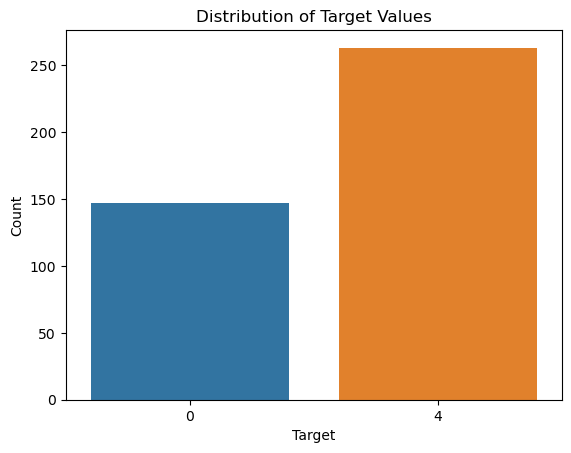

In [70]:
# Plotting the distribution 
sns.countplot(x='target', data=df2)
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

As you can see there is almost double the amount of positive sentiments as there are negative, but I think that this shouldn't be too much of an issue. 

Now I will perform the same EDA on the MultiClass labelled test data to see the differences.

In [71]:
df3 = pd.read_csv('Data/MultiClassLabelledCustomTwitterSentiments.csv', encoding='utf-8')
# Display info
print(f"Num rows: {df3.shape[0]}")
df3.head()

Num rows: 410


,text,target
0,I don't know about you but I think Alden Ehren...,4
1,The PR for DLPack support in CuPy has been mer...,4
2,Oh ffs. Such bs. How did he react to recent Co...,0
3,Super cool reimplementation (+ new stuff) of ...,4
4,Now targeting June 1 launch of SES-12 from Pad...,2


In [72]:
df3.describe()

,target
count,410.000000
mean,2.209756
std,1.313798
min,0.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,4.000000


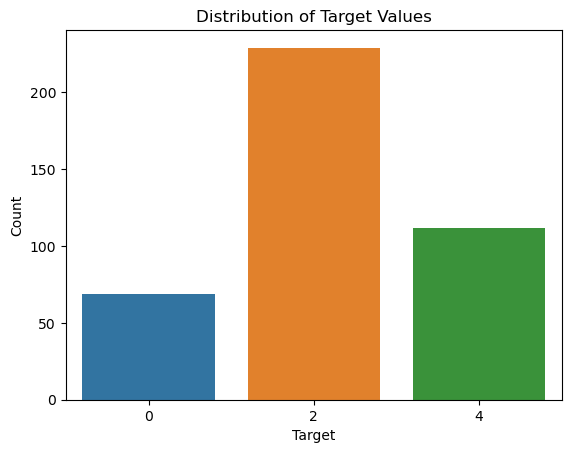

In [73]:
# Plotting the distribution 
sns.countplot(x='target', data=df3)
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()